In [1]:
!pip install scanpy -q
!pip install scikit-optimize -q
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import shutil
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
from keras_tuner import Hyperband

seed = 2023 # DO NOT CHANGE!

In [ ]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")
print(f"tensorflow version: {tf.__version__}")
print(f"keras tuner version: {kt.__version__}")

sklearn version: 1.2.2
numpy version: 1.25.2
pandas version: 2.0.3
matplotlib version: 3.7.1
scanpy version: 1.10.1
tensorflow version: 2.15.0
keras tuner version: 1.4.7


# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BRAIN = sp.read_h5ad("/content/drive/MyDrive/Design/mouse_brain.h5ad")

In [5]:
print(f"The data has {BRAIN.n_obs} observations and {BRAIN.n_vars} features.")

The data has 6862 observations and 21808 features.


In [ ]:
BRAIN.X

<6862x21808 sparse matrix of type '<class 'numpy.float64'>'
	with 49196404 stored elements in Compressed Sparse Row format>

In [ ]:
BRAIN.obs['predicted.id']

AAACGAAAGAAGGGCG-1         Astro
AAACGAAAGAGTTCGG-1            L4
AAACGAAAGCTACGTT-1       L2/3 IT
AAACGAAAGGATGTAT-1    Macrophage
AAACGAAAGTGAACCG-1           Vip
                         ...    
TTTGTGTGTTACACTG-1         L6 IT
TTTGTGTTCCGATTGA-1         L6 IT
TTTGTGTTCGGAAAGC-1         Oligo
TTTGTGTTCTATATCC-1            L4
TTTGTGTTCTTCCACG-1         L5 PT
Name: predicted.id, Length: 6862, dtype: object

6862 number of cells, with 22 total cell types


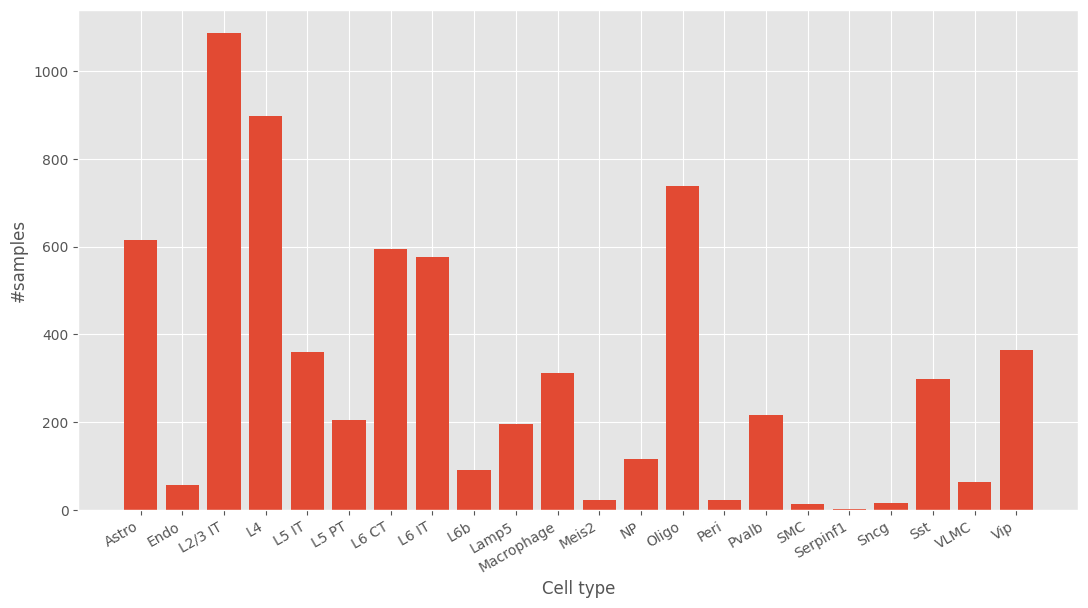

In [6]:
cell_types, type_numbers = np.unique(BRAIN.obs['predicted.id'], return_counts=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(type_numbers)} number of cells, with {len(cell_types)} total cell types")
ax.bar(list(map(str, cell_types)), type_numbers)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

# Filtering + Train/Test Split

In [7]:
cutoff = 0.001
# Cut off

cell_types, type_numbers = np.unique(BRAIN.obs['predicted.id'], return_counts=True)
bad_types = cell_types[type_numbers / len(BRAIN.obs['predicted.id'])<cutoff]
print(bad_types)

bad_types_mask = np.invert(np.isin(BRAIN.obs['predicted.id'], bad_types))
X = BRAIN.X[bad_types_mask]
Y = BRAIN.obs['predicted.id'][bad_types_mask]

print(Y.shape)

['Serpinf1']
(6860,)


6860 number of cells, with 21 total cell types


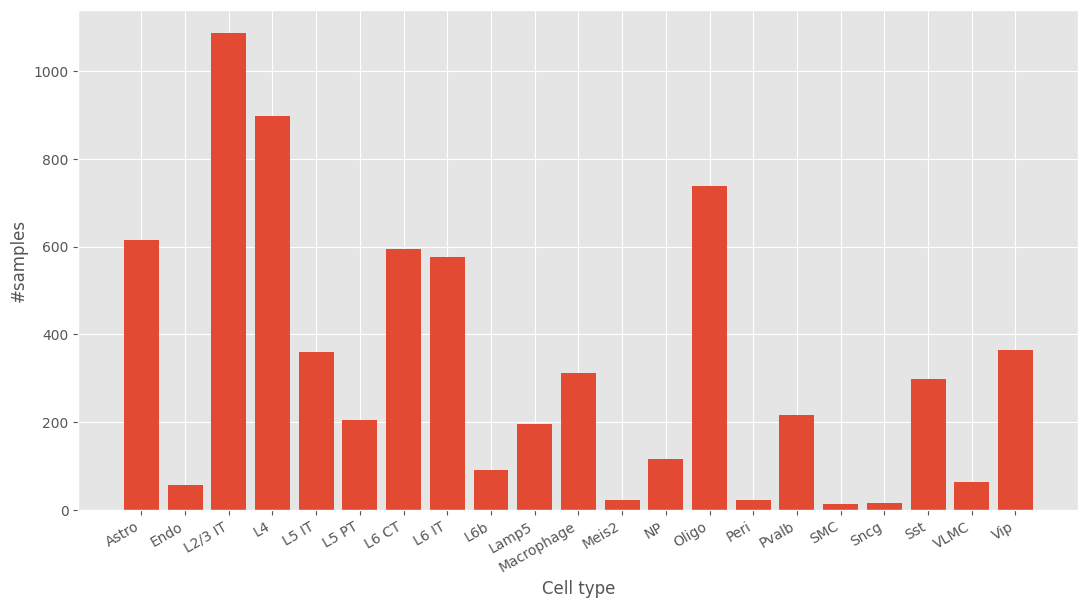

In [8]:
cell_types, type_numbers = np.unique(Y, return_counts=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(type_numbers)} number of cells, with {len(cell_types)} total cell types")
ax.bar(list(map(str, cell_types)), type_numbers)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

In [9]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed, stratify=None)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1333, random_state=seed, stratify=Y_train_val)

n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

print(f"{n_train} train samples")
print(f"{n_val} validation samples")
print(f"{n_test} test samples")
print(f"{n_train/(n_train+n_val+n_test)*100:.2f}% of samples used for training")
print(f"{n_val/(n_train+n_val+n_test)*100:.2f}% of samples used for validation")
print(f"{n_test/(n_train+n_val+n_test)*100:.2f}% of samples used for testing")

4459 train samples
686 validation samples
1715 test samples
65.00% of samples used for training
10.00% of samples used for validation
25.00% of samples used for testing


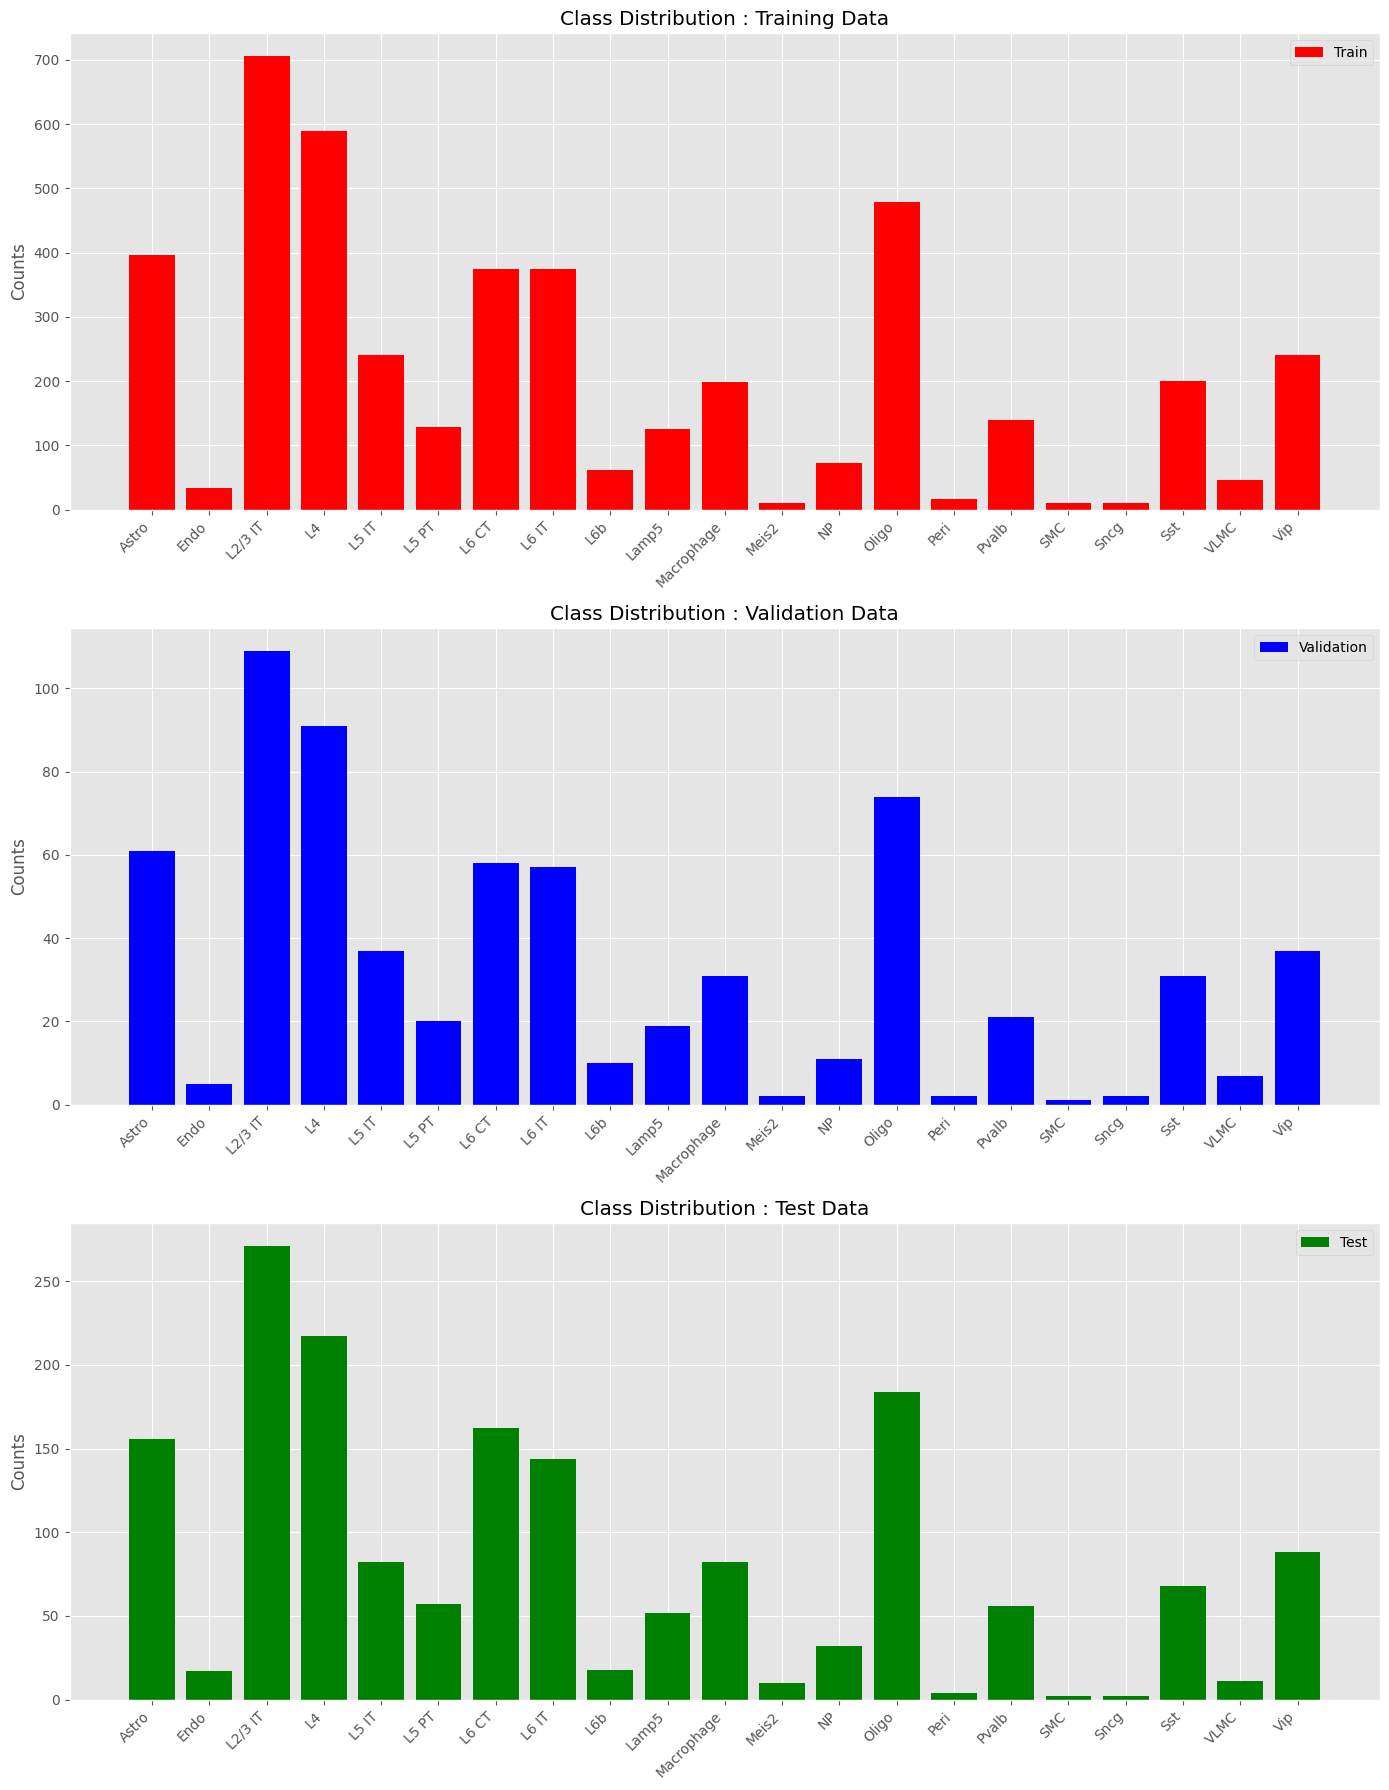

In [10]:
def get_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

train_dist = get_class_distribution(Y_train)
val_dist = get_class_distribution(Y_val)
test_dist = get_class_distribution(Y_test)


all_classes = sorted(set(train_dist.keys()).union(set(val_dist.keys()), set(test_dist.keys())))
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}

def prepare_plot_data(distribution):
    indices = []
    counts = []
    for cls in all_classes:
        indices.append(class_to_index[cls])
        counts.append(distribution.get(cls, 0))
    return indices, counts

train_indices, train_counts = prepare_plot_data(train_dist)
val_indices, val_counts = prepare_plot_data(val_dist)
test_indices, test_counts = prepare_plot_data(test_dist)

fig, ax = plt.subplots(3, 1, figsize=(14, 18))

ax[0].bar(train_indices, train_counts, color='r', label='Train')
ax[1].bar(val_indices, val_counts, color='b', label='Validation')
ax[2].bar(test_indices, test_counts, color='g', label='Test')

ax[0].set_title('Class Distribution : Training Data')
ax[1].set_title('Class Distribution : Validation Data')
ax[2].set_title('Class Distribution : Test Data')

ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[2].set_ylabel('Counts')

ax[0].legend()
ax[1].legend()
ax[2].legend()

for a in ax:
    a.set_xticks(range(len(all_classes)))
    a.set_xticklabels(all_classes, rotation=45, ha='right')
    a.tick_params(axis='x', labelbottom=True)

plt.tight_layout()
plt.show()

In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(Y)

Y_train_encoded = label_encoder.transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
Y_full = label_encoder.transform(Y)

num_classes = len(np.unique(Y_train_encoded))

print("Number of classes:", len(label_encoder.classes_))

Number of classes: 21


In [12]:
def sparse_to_dense(sparse):
    return tf.convert_to_tensor(sparse.todense(), dtype=tf.float32)

X_train_dense = sparse_to_dense(X_train)
X_val_dense = sparse_to_dense(X_val)
X_test_dense = sparse_to_dense(X_test)
X_full_dense = sparse_to_dense(X)

# Model training

In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)

In [13]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

## MLP

### Reload tuner

In [ ]:
dest_folder = '/content/BRAIN_MLP_final'
src_folder = '/content/drive/MyDrive/Design/BRAIN_MLP_final'

shutil.copytree(src_folder, dest_folder)

'/content/BRAIN_MLP'

In [14]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

In [15]:
with strategy.scope():
    def model_builder(hp):
        model = Sequential()
        units = hp.Int('units', min_value=len(np.unique(Y_train)), max_value=7*len(np.unique(Y_train)), step=len(np.unique(Y_train)))
        hp_alpha = hp.Float('alpha', min_value=0.0, max_value=0.1, step=0.01)
        hp_batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512])
        model.add(Dense(units=units, activation='relu', kernel_regularizer=l2(hp_alpha), input_dim=X_train_dense.shape[1]))
        model.add(Dense(num_classes, activation='softmax'))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
        if hp_optimizer == 'adam':
            optimizer = Adam(learning_rate=hp_learning_rate)
        else:
            hp_momentum = hp.Float('momentum', min_value=0.5, max_value=0.99, step=0.1)
            optimizer = SGD(learning_rate=hp_learning_rate, momentum=hp_momentum)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[SparseCategoricalAccuracy()])
        return model

In [ ]:
with strategy.scope():
    tuner = Hyperband(
        model_builder,
        objective='val_sparse_categorical_accuracy',
        max_epochs=150,
        factor=3,
        hyperband_iterations=1,
        directory='BRAIN_MLP_final',
        project_name='BRAIN_MLP_final',
        overwrite=False
    )
    tuner.search(X_train_dense, Y_train_encoded, epochs=10, validation_data=(X_val_dense, Y_val_encoded), callbacks=[reduce_lr, early_stopping])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from BRAIN_MLP/BRAIN_MLP/tuner0.json


In [21]:
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal alpha for L2 regularization: {best_hps.get('alpha')}")
print(f"Optimal batch size: {best_hps.get('batch_size')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
print(f"Optimal optimizer: {best_hps.get('optimizer')}")
if best_hps.get('optimizer') == 'sgd':
    print(f"Optimal momentum for SGD: {best_hps.get('momentum')}")

Optimal number of units: 126
Optimal alpha for L2 regularization: 0.01
Optimal batch size: 128
Optimal learning rate: 0.0001
Optimal optimizer: adam


Backup Tuner

In [22]:
src_folder = '/content/BRAIN_MLP_final'
dest_folder = '/content/drive/MyDrive/Design/BRAIN_MLP_final'
shutil.copytree(src_folder, dest_folder)

'/content/drive/MyDrive/Design/BRAIN_MLP_final'

Combine training and validation for final model training

In [18]:
X_train_full = tf.concat([X_train_dense, X_val_dense], axis=0)
Y_train_full = np.concatenate([Y_train_encoded, Y_val_encoded], axis=0)

Build the model with the best hyperparameters


In [25]:
def build_model(best_hps):
    with strategy.scope():
        model = Sequential([
            Dense(units=best_hps.get('units'), activation='relu',
                  kernel_regularizer=l2(best_hps.get('alpha')),
                  input_dim=X_train_full.shape[1]),
            Dense(num_classes, activation='softmax')
        ])

        if best_hps.get('optimizer') == 'adam':
            optimizer = Adam(learning_rate=best_hps.get('learning_rate'))
        else:
            optimizer = SGD(learning_rate=best_hps.get('learning_rate'), momentum=best_hps.get('momentum'))

        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[SparseCategoricalAccuracy()])
    return model

model = build_model(best_hps)

Train the final model for 53 epochs.

In [ ]:
model.fit(X_train_full, Y_train_full, epochs=53, batch_size=best_hps.get('batch_size'))


Evaluate on test set and make predictions

In [27]:
test_loss, test_accuracy = model.evaluate(X_test_dense, Y_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

54/54 [==============================] - 0s 3ms/step - loss: 0.5371 - sparse_categorical_accuracy: 0.8711
Test Loss: 0.5370942950248718
Test Accuracy: 0.8711370229721069


In [28]:
test_pred = model.predict(X_test_dense).argmax(axis=1)
train_pred = model.predict(X_train_dense).argmax(axis=1)
full_pred = model.predict(X_full_dense).argmax(axis=1)

print("==== Accuracy with Subtypes ====")
print(f"Train accuracy: {accuracy_score(Y_train_encoded, train_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test_encoded, test_pred):.5f}")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train_encoded, train_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test_encoded, test_pred):.5f}")

215/215 [==============================] - 0s 2ms/step
==== Accuracy with Subtypes ====
Train accuracy: 1.00000
Test accuracy: 0.87114
Balanced Train Accuracy: 1.00000
Balanced Test Accuracy: 0.68499


In [31]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, test_pred_labels))

              precision    recall  f1-score   support

       Astro       0.96      1.00      0.98       156
        Endo       1.00      1.00      1.00        17
     L2/3 IT       0.87      0.97      0.92       271
          L4       0.86      0.92      0.89       217
       L5 IT       0.79      0.71      0.75        82
       L5 PT       0.93      0.96      0.95        57
       L6 CT       0.95      0.99      0.97       162
       L6 IT       0.84      0.68      0.75       144
         L6b       0.94      0.83      0.88        18
       Lamp5       0.97      0.58      0.72        52
  Macrophage       0.95      1.00      0.98        82
       Meis2       0.00      0.00      0.00        10
          NP       0.96      0.78      0.86        32
       Oligo       0.78      1.00      0.87       184
        Peri       1.00      0.25      0.40         4
       Pvalb       1.00      0.95      0.97        56
         SMC       0.00      0.00      0.00         2
        Sncg       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the  model

In [29]:
model_save_path = '/content/drive/MyDrive/Design/BRAIN/BRAIN_final.keras'
model.save(model_save_path)

Load the final model if needed

In [ ]:
model_load_path = '/content/drive/MyDrive/Design/BRAIN/BRAIN_final.keras'
loaded_model = load_model(model_load_path)

if best_hps.get('optimizer') == 'adam':
    optimizer = Adam(learning_rate=best_hps.get('learning_rate'))
else:
    optimizer = SGD(learning_rate=best_hps.get('learning_rate'), momentum=best_hps.get('momentum'))

loaded_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[SparseCategoricalAccuracy()])

# Save predictions

In [30]:
test_pred_labels = label_encoder.inverse_transform(test_pred)
train_pred_labels = label_encoder.inverse_transform(train_pred)
full_pred_labels = label_encoder.inverse_transform(full_pred)

pred_pickle = {
    'test_pred_labels': test_pred_labels,
    'train_pred_labels': train_pred_labels,
    'full_pred_labels': full_pred_labels
}

file_path = '/content/drive/MyDrive/Design/BRAIN/brain_pred_final.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(pred_pickle, file)